In [1]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = set(stopwords.words('english'))

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

In [2]:
from dirtojsonl import process_directory

process_directory('c:\\tools\\code\\ResumeAnalytics\\Candidate Resumes', 'candidate.jsonl')
process_directory('c:\\tools\\code\\ResumeAnalytics\\Target Resumes', 'target.jsonl')
process_directory('c:\\tools\\code\\ResumeAnalytics\\Other Resumes', 'other.jsonl')

import json
with open('candidate.jsonl', 'r') as cf, open('target.jsonl', 'r') as tf, open('other.jsonl', 'r') as of:
  candidate = [json.loads(line) for line in cf]
  target = [json.loads(line) for line in tf]
  other = [json.loads(line) for line in of]
    
mashed_target = ''
doc_set = []
other_set = []
for t in target:
  doc_set.append(t['content'])
for o in other:
  other_set.append(o['content'])

can_set = []
for c in candidate:
  can_set.append(c['content'])


In [3]:

# list for tokenized documents in loop
texts = []

# loop through document list
for i in doc_set:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)

# Do it again for other list
for i in other_set:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)
    
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)

# Remove extreme tokens from the dictionary
dictionary.filter_extremes(no_below=2, no_above=0.9, keep_n=100000)
    
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

# Seed the randomness so changes are more easily apparent (best practice)
import numpy
import random
numpy.random.seed(1)
random.seed(1)

# Transform bag of words into TF/IDF
tfidf = gensim.models.tfidfmodel.TfidfModel(corpus, id2word = dictionary, normalize=True)

# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(tfidf[corpus], num_topics=10, id2word = dictionary, passes=30)

In [4]:
import math

# Define Jensen Shannon Distance
# Jensen-Shannon Divergence is
# 1/2 (DKL(P||M) + DKL(Q||M))
# Where M = 1/2(P+Q) and
# DKL(X||Y) = Sum(i) of X(i) log X(i)/Y(i)
# Jensen-Shannon Distance is just the square root of the Divergence
def js_distance(p,q):
    import warnings
    warnings.filterwarnings("ignore", category = RuntimeWarning)
    p = numpy.array(p)
    q = numpy.array(q)
    dkl1 = p*numpy.log(2*p/(p+q))
    dkl2 = q*numpy.log(2*q/(p+q))
    dkl1[numpy.isnan(dkl1)] = 0
    dkl2[numpy.isnan(dkl2)] = 0
    div = 0.5*numpy.sum(dkl1+dkl2)
    dist = math.sqrt(div)
    return dist

def doc_similarity(targ, comp):
    d = dict(comp)
    x = []
    y = []
    for topic in targ:
        if topic[0] in d:
            x.append(topic[1])
            y.append(d[topic[0]])
    return js_distance(x, y)

In [5]:
print (ldamodel.print_topics(num_topics = 10, num_words = 8))

[(0, '0.004*yr + 0.003*dame + 0.003*card + 0.002*notr + 0.002*patient + 0.002*chines + 0.002*scholarship + 0.002*relief'), (1, '0.002*character + 0.002*fiber + 0.001*fratern + 0.001*frontend + 0.001*scout + 0.001*portion + 0.001*red + 0.001*stack'), (2, '0.004*yr + 0.002*right + 0.002*imag + 0.002*cisco + 0.002*ticket + 0.002*penetr + 0.002*workflow + 0.002*anti'), (3, '0.002*game + 0.002*portfolio + 0.002*veteran + 0.002*santa + 0.002*julia + 0.002*equat + 0.002*broker + 0.002*patient'), (4, '0.003*cruz + 0.002*hopkin + 0.002*linthicum + 0.002*svn + 0.002*scrum + 0.002*tester + 0.002*missil + 0.002*09'), (5, '0.003*le + 0.002*loui + 0.002*io + 0.002*st + 0.002*oblig + 0.002*tx + 0.002*revers + 0.002*cs'), (6, '0.003*stanford + 0.003*3d + 0.002*gi + 0.002*madison + 0.002*jame + 0.002*men + 0.002*automot + 0.002*writer'), (7, '0.002*radio + 0.002*arrang + 0.002*calendar + 0.002*hire + 0.002*presid + 0.002*soa + 0.001*soccer + 0.001*domest'), (8, '0.004*yr + 0.003*steven + 0.002*newport 

In [6]:
print (">>>>Target:<<<<\n")
# Get array of target topics
target_topics = []
for i in target:
    raw = i['content'].lower()
    tokens = tokenizer.tokenize(raw)
    stopped_tokens = [i for i in tokens if not i in en_stop]
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    print (i['name'])
    topics = ldamodel.get_document_topics(dictionary.doc2bow(stemmed_tokens))
    print (topics)
    target_topics.append(topics)
print (target_topics)
    
    
print ("\n\n>>>>Other:<<<<\n")
for i in other:
    raw = i['content'].lower()
    tokens = tokenizer.tokenize(raw)
    stopped_tokens = [i for i in tokens if not i in en_stop]
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    #print (i['name'])
    #print (ldamodel.get_document_topics(dictionary.doc2bow(stemmed_tokens)))    
    
print ("\n\n>>>>Candidates:<<<<\n")

for i in candidate:
    raw = i['content'].lower()
    tokens = tokenizer.tokenize(raw)
    stopped_tokens = [i for i in tokens if not i in en_stop]
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    i['distance'] = 0
    for t in target_topics:
        i['distance'] = i['distance'] + doc_similarity(t, ldamodel.get_document_topics(dictionary.doc2bow(stemmed_tokens)))
    # divide to obtain average distance to all target resumes
    # i['distance'] = i['distance'] / len(target_topics) Except this seems to vary by doc
    print (i['name'] + ": " + str(i['distance']))
    print (ldamodel.get_document_topics(dictionary.doc2bow(stemmed_tokens)))



>>>>Target:<<<<

Brandon Herzog Resume 2010.txt
[(6, 0.23148103577233559), (9, 0.76529287493029052)]
DrewChenResume.txt
[(8, 0.13520235054745486), (9, 0.86142112421076356)]
Kyle Shaw Resume 2016.txt
[(3, 0.10021675238821243), (4, 0.031463923195091684), (9, 0.86209443915181394)]
Resume_Alejandro_Hired.txt
[(6, 0.079696540322581888), (8, 0.15148626112524971), (9, 0.76672082094101912)]
ToddOldResume.txt
[(5, 0.20417978947122195), (9, 0.79122202878506864)]
Matthew Daye_resume.docx
[(0, 0.20657726139664001), (9, 0.79001809221792774)]
[[(6, 0.23148103577233559), (9, 0.76529287493029052)], [(8, 0.13520235054745486), (9, 0.86142112421076356)], [(3, 0.10021675238821243), (4, 0.031463923195091684), (9, 0.86209443915181394)], [(6, 0.079696540322581888), (8, 0.15148626112524971), (9, 0.76672082094101912)], [(5, 0.20417978947122195), (9, 0.79122202878506864)], [(0, 0.20657726139664001), (9, 0.79001809221792774)]]


>>>>Other:<<<<



>>>>Candidates:<<<<

Aberra Aimen 7494924 Resume.txt: 0.7293685904

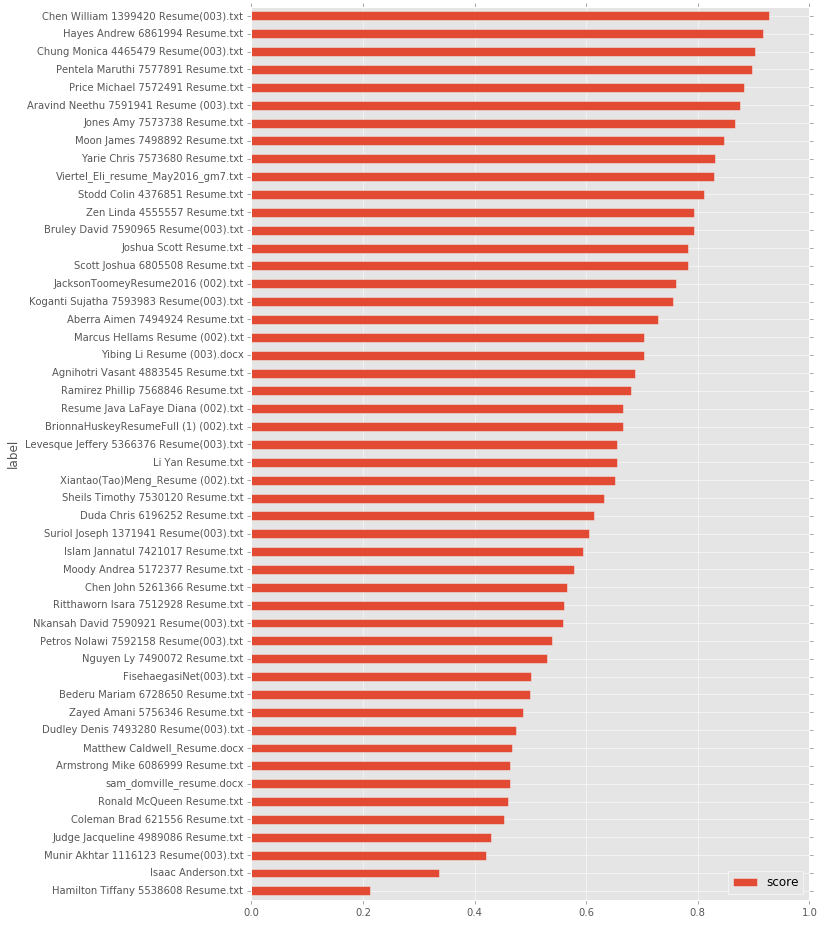

In [7]:
%matplotlib inline
import pandas as pd
import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 16.0)

result = []
for i in range(len(candidate)):
    result.append((candidate[i]['name'], candidate[i]['distance']))
result = sorted(result, key=lambda x: x[1], reverse=False)

df = pd.DataFrame(result, columns=['label', 'score'])
df[:50].plot(kind='barh', x='label', y='score');